# Graph worlds

This environment demonstrates agents that can navigate a graph and find an object. Object is only visible when agent is at the same location as the object.

In [1]:
import jax.numpy as jnp
from jax import random as jr

key = jr.PRNGKey(0)

Start by generating a graph of locations

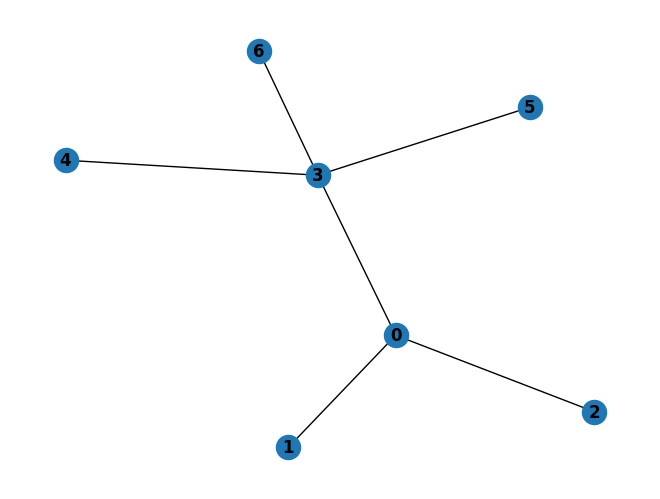

In [2]:
import networkx as nx
from pymdp.jax.envs import GraphEnv
from pymdp.jax.envs.graph_worlds import generate_connected_clusters

graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
nx.draw(graph, with_labels=True, font_weight="bold")

Now we can create a GraphEnv given this graph. We specify two object locations and two agent locations. This will effectively create the environment with a batch size of 2.

In [3]:
env = GraphEnv(graph, object_locations=[3, 5], agent_locations=[0, 1])

To create an Agent, we reuse the environment's A and B tensors, but give the agent a uniform initial belief about the object location, and a preference to find (see) the object.

In [4]:
from pymdp.jax.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

agent = Agent(A, B, C, D, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=2, apply_batch=False)

Using the rollout function, we can easily simulate two agents in parallel for 10 timesteps...

In [5]:
from pymdp.jax.envs.rollout import rollout

last, result, env = rollout(agent, env, 10, key)

The result dict contains the executed actions, observations, environment state and beliefs over states and policies.

In [9]:
result.keys()

dict_keys(['action', 'env', 'observation', 'qpi', 'qs'])

The beliefs result is an array for each state factor, and the shape is [batch_size x time x factor_size]

In [10]:
print(len(result["qs"]))
print(result["qs"][0].shape)

2
(2, 10, 7)


We can plot the agent's beliefs over time.

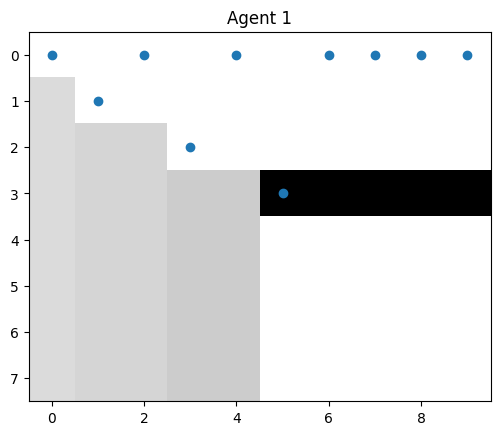

In [11]:
agent_idx = 0

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.title.set_text("Agent 1")

# we plot the agent location belief as blue dots
T = result["qs"][0].shape[1]
locations = [jnp.argmax(result["qs"][0][agent_idx, t, :]) for t in range(T)]
ax.scatter(
    jnp.arange(T), locations, c="tab:blue"
)
# and object location beliefs as greyscale intensity
ax.imshow(result["qs"][1][agent_idx, :, :].T, cmap="gray_r", vmin=0.0, vmax=1.0)